<hr size="5" />

### **<font color='DarkCyan'>Salzburg University of Applied Sciences - 2023**  
#### **<font color='DarkCyan'>Information Technology & Systems Engineering**

# **<font color='GoldenRod'>Master Thesis**  
## **<font color='GoldenRod'>Deep Learning for Advancing Animal Breeding: A Study on Austrian Fleckvieh Cattle**

<hr size="5">

#### Student Name: Jakob Ganitzer
#### Degree Program:  ITSM-B

<hr size="5" />

### Imports

In [1]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
wandb_project_name = "_"
wandb_run_name = "_"
entity="_"
wandb.init(project=wandb_project_name, name=wandb_run_name, entity=entity)

### Load Data

In [2]:
dataRoot = "/data/_"

In [3]:
heritability = "/h40"

In [4]:
phenotype_path = dataRoot + heritability + heritability + "_simu.dat"
snp_path = dataRoot + heritability + heritability + "_simu.snp"
benchmark_path = dataRoot + heritability + heritability + "_simu.bv"
pedigree_path = dataRoot + heritability + heritability + "_simu.ped"
snpPos_path = dataRoot + heritability + heritability + "_simu_snp.txt"
qtl_path = dataRoot + heritability + heritability + "_simu_qtl.txt"

In [5]:
trainPath = '/snp_pheno_BPpos_maf_new.parquet'
testPath = '/snpTruePheno_gen30_BPpos_maf_new.parquet'

In [25]:
df_train_maf = pd.read_parquet(dataRoot + heritability + trainPath, engine='pyarrow')

In [26]:
df_test_maf = pd.read_parquet(dataRoot + heritability + testPath, engine='pyarrow')

In [29]:
df_train_maf.drop(columns=['phenotype', 'id'], inplace=True)

In [30]:
df_test_maf.drop(columns=['phenotype', 'id'], inplace=True)

In [8]:
df_ped = pd.read_csv(pedigree_path, sep=" ", header=None, names=["id", "sire", "dam", "generation"])

In [18]:
df_snpPos = pd.read_csv(snpPos_path, sep=" ")

In [20]:
df_qtl = pd.read_csv(qtl_path, sep=" ")

In [10]:
df_test_maf = pd.read_parquet(dataRoot + heritability + '/snpTruePheno_gen30_BPpos_maf_new.parquet', engine='pyarrow')

In [12]:
df_ped

,id,sire,dam,generation
1.0,0,0.0,0,M
2.0,0,0.0,0,M
3.0,0,0.0,0,M
4.0,0,0.0,0,M
5.0,0,0.0,0,M
...,...,...,...,...
1302196.0,1247495,1138222.0,30,F
1302197.0,1220769,1162800.0,30,M
1302198.0,1242187,1083544.0,30,F
1302199.0,1222833,1134422.0,30,M


In [19]:
df_snpPos

,id,chr,site,BPpos
0,1,1,1,0
1,2,1,2,14939
2,3,1,4,56166
3,4,1,8,109246
4,5,1,10,126268
...,...,...,...,...
49795,49796,30,4218,99759687
49796,49797,30,4219,99763695
49797,49798,30,4221,99849452
49798,49799,30,4222,99849783


In [21]:
df_qtl

,id,chr,site,BPpos,eff
0,1,1,203,5039213,0.125499
1,2,1,352,8491435,-0.047612
2,3,1,459,11581435,0.054814
3,4,1,640,15389863,-0.095454
4,5,1,645,15456956,-0.062020
...,...,...,...,...,...
895,896,30,3394,79599063,-0.024650
896,897,30,3410,80026127,0.110102
897,898,30,3671,86337673,-0.005790
898,899,30,3946,92987513,0.018326


In [5]:
df_benchmark = pd.read_csv(benchmark_path, sep=" ")

In [6]:
df_benchmark

,id,gen,true,sstep,konv
0,1.0,0,1.122668,-0.6755,-4.7152
1,2.0,0,-0.246784,-2.3505,-6.3914
2,3.0,0,0.354400,-1.9892,-6.0297
3,4.0,0,0.028821,-2.0263,-6.0674
4,5.0,0,0.544295,-1.5597,-5.6007
...,...,...,...,...,...
1302195,1302196.0,30,12.328599,9.8970,6.9155
1302196,1302197.0,30,13.126906,11.8030,6.9374
1302197,1302198.0,30,12.830373,11.2940,7.0339
1302198,1302199.0,30,12.470817,10.6690,7.1215


In [19]:
if len(set(df.columns)) == len(df.columns):
    print('No duplicate columns')
else:
    print('Duplicate columns found')

No duplicate columns


In [20]:
len(set(df.columns))

49802

In [26]:
df_pheno = pd.read_csv(phenotype_path , sep=" ", header=None, names=["id", "fixed_effect", "phenotype"])

In [17]:
df_snp = pd.read_csv(snp_path, sep=" ", header=None)

In [5]:
df_maf = pd.read_parquet(dataRoot + heritability + '/snp_pheno_BPpos_maf_new.parquet', engine='pyarrow')

In [23]:
def alleleFrequencyEncoding(df):
    for col in df.columns:
        # Count the number of 0s and 1s in the column
        D = (df[col] == 0).sum()
        H = (df[col] == 1).sum()
        N = df.shape[0]
        
        # Calculate p and q
        p = ((2*D) + H) / (2*N)
        q = 1 - p
        
        # Replace values in the column
        df[col] = df[col].apply(lambda x: p*p if x == 0 else (2*p*q if x == 1 else q*q))
    
    return df

In [74]:

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),3), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for idx, snp in np.ndenumerate(sequence):
        if snp == 0:
            zeros_array[idx][0] = 1
        elif snp == 1:
            zeros_array[idx][1] = 1
        elif snp == 2:
            zeros_array[idx][2] = 1
        else:
            raise RuntimeError("Unsupported value: " + str(snp))
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.values])

In [26]:
X_train_alleleEncoded = alleleFrequencyEncoding(data)

In [27]:
X_train_alleleEncoded

,snp_1,snp_2,snp_3,snp_4,snp_5,snp_6,snp_7,snp_8,snp_9,snp_10,...,snp_49791,snp_49792,snp_49793,snp_49794,snp_49795,snp_49796,snp_49797,snp_49798,snp_49799,snp_49800
29,0.480988,0.467168,0.467168,0.466847,0.466847,0.466847,1.0,0.971457,0.330347,0.548525,...,0.420877,0.420877,0.955506,0.996254,0.467168,0.99376,0.904877,0.487597,0.715082,0.715082
535,0.480988,0.394541,0.394541,0.395327,0.395327,0.395327,1.0,0.971457,0.626077,0.384199,...,0.420877,0.420877,0.955506,0.996254,0.394541,0.99376,0.904877,0.334952,0.715082,0.715082
695,0.162006,0.394541,0.394541,0.395327,0.395327,0.395327,1.0,0.971457,0.626077,0.548525,...,0.455747,0.455747,0.955506,0.996254,0.394541,0.99376,0.904877,0.334952,0.715082,0.715082
557,0.357006,0.467168,0.467168,0.466847,0.466847,0.466847,1.0,0.971457,0.626077,0.384199,...,0.123377,0.123377,0.955506,0.996254,0.467168,0.99376,0.904877,0.487597,0.261087,0.261087
836,0.162006,0.394541,0.394541,0.395327,0.395327,0.395327,1.0,0.971457,0.626077,0.384199,...,0.455747,0.455747,0.955506,0.996254,0.467168,0.99376,0.904877,0.487597,0.715082,0.715082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.162006,0.394541,0.394541,0.395327,0.395327,0.395327,1.0,0.971457,0.626077,0.548525,...,0.420877,0.420877,0.955506,0.996254,0.394541,0.99376,0.904877,0.334952,0.715082,0.715082
270,0.357006,0.467168,0.467168,0.466847,0.466847,0.466847,1.0,0.971457,0.330347,0.384199,...,0.420877,0.420877,0.955506,0.996254,0.394541,0.99376,0.904877,0.334952,0.715082,0.715082
860,0.480988,0.467168,0.467168,0.466847,0.466847,0.466847,1.0,0.971457,0.626077,0.548525,...,0.420877,0.420877,0.955506,0.996254,0.138291,0.99376,0.904877,0.177452,0.715082,0.715082
435,0.480988,0.467168,0.467168,0.466847,0.466847,0.466847,1.0,0.971457,0.330347,0.548525,...,0.455747,0.455747,0.955506,0.996254,0.394541,0.99376,0.904877,0.334952,0.715082,0.715082


In [28]:
def one_hot_encode(df):
    
    #Takes in a dataframe and returns a new dataframe with one-hot encoded values.
    
    # Get a list of all unique values in the dataframe
    unique_values = df.stack().unique()

    # Create a dictionary mapping each unique value to a one-hot encoded vector
    encoding_dict = {value: [int(value==val) for val in unique_values] for value in unique_values}

    # Replace each value in the dataframe with its corresponding one-hot encoded vector
    encoded_df = df.applymap(lambda x: encoding_dict[x])

    # Flatten the one-hot encoded vectors into separate columns
    encoded_df = pd.DataFrame(encoded_df.stack().tolist(), index=encoded_df.index)

    # Rename the columns to match the original values
    encoded_df.columns = [f'col_{val}' for val in unique_values]

    return encoded_df

In [ ]:
X_train_oneHotEncoded = one_hot_encode(data)

### ADD Pedigree

In [9]:
snp_one_hot = pd.read_parquet(dataRoot + heritability + '/snp_maf_one_hot.parquet', engine='pyarrow')

In [5]:
snp_pheno = pd.read_parquet(dataRoot + heritability + '/snp_pheno_BPpos_maf.parquet', engine='pyarrow')

In [10]:
snp_one_hot.head()

,snp_10000_3062611_0,snp_10000_3062611_1,snp_10000_3062611_2,snp_10001_3185285_0,snp_10001_3185285_1,snp_10001_3185285_2,snp_10002_3205483_0,snp_10002_3205483_1,snp_10002_3205483_2,snp_10005_3466532_0,...,snp_9998_2910524_1,snp_9998_2910524_2,snp_99_6405588_0,snp_99_6405588_1,snp_99_6405588_2,snp_9_562825_0,snp_9_562825_1,snp_9_562825_2,phenotype,id
0,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,7.262773,840202.0
1,0,1,0,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,10.131145,840204.0
2,1,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,8.886089,840206.0
3,1,0,0,1,0,0,1,0,0,1,...,1,0,1,0,0,1,0,0,12.062859,840208.0
4,0,1,0,1,0,0,1,0,0,0,...,1,0,1,0,0,1,0,0,10.406305,840210.0


In [6]:
df_ped = pd.read_csv(pedigree_path, sep=" ", header=None, names=["id", "sire", "dam", "generation", "sex"])

In [12]:
df_ped

,id,sire,dam,generation,sex
0,1.0,0,0.0,0,M
1,2.0,0,0.0,0,M
2,3.0,0,0.0,0,M
3,4.0,0,0.0,0,M
4,5.0,0,0.0,0,M
...,...,...,...,...,...
1302195,1302196.0,1247495,1138222.0,30,F
1302196,1302197.0,1220769,1162800.0,30,M
1302197,1302198.0,1242187,1083544.0,30,F
1302198,1302199.0,1222833,1134422.0,30,M


In [13]:
df_snp_pheno_onehot_ped = snp_one_hot.merge(df_ped, on="id")

In [7]:
df_snp_pheno_ped = snp_pheno.merge(df_ped, on="id")

In [15]:
# unique labels in generation column of df_snp_pheno_ped
df_snp_pheno_onehot_ped["generation"].unique()

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [21]:
df_snp_pheno_onehot_ped.to_parquet(dataRoot + heritability + '/snp_maf_one_hot_ped.parquet')

In [8]:
df_snp_pheno_ped.to_parquet(dataRoot + heritability + '/snp_maf_ped.parquet')

### EDA

In [ ]:
df_snp_gen30_ped = pd.read_parquet(dataRoot + heritability + '/snpTruePheno_gen30_BPpos_maf_one_hot_ped.parquet', engine='pyarrow')


In [12]:
# Merge and keep only IDs from df1
merged_df = df_snp_gen30_ped.merge(df_benchmark, on='id', how='left')

benchmarkGen30 = merged_df[['id', 'true', 'sstep', 'konv']].copy()

In [5]:
df_snp_pheno_benchmark = pd.read_parquet(dataRoot + heritability + '/snp_pheno_BPpos_benchmark.parquet', engine='pyarrow')

In [7]:
df_snp_pheno_benchmark.shape

(210000, 49805)

In [8]:
df_snp_pheno_benchmark.isnull().sum()

id                    0
snp_1_0               0
snp_2_14939           0
snp_3_56166           0
snp_4_109246          0
                     ..
snp_49800_99879457    0
phenotype             0
true                  0
sstep                 0
konv                  0
Length: 49805, dtype: int64

In [9]:
df_snp_pheno_benchmark.duplicated().sum()

0

<Axes: xlabel='konv', ylabel='Count'>

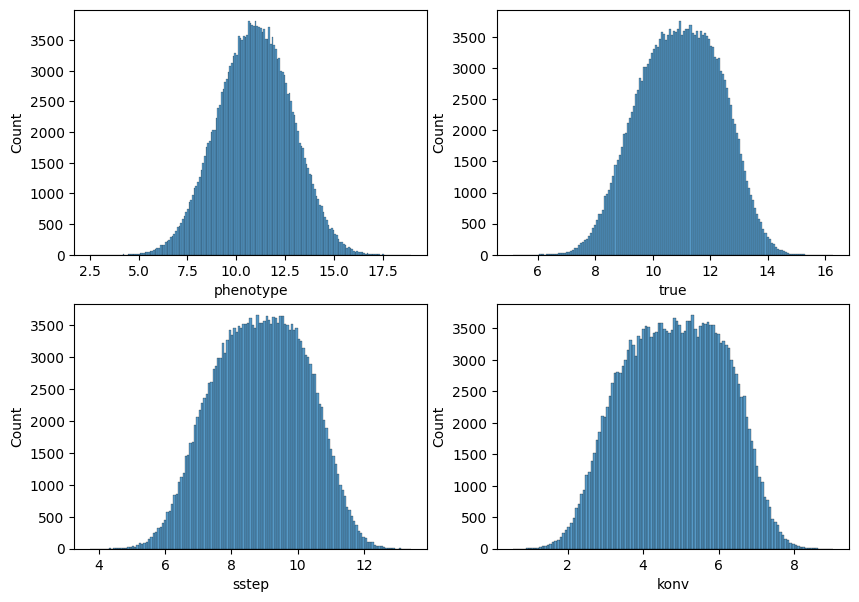

In [11]:
# Show distribution of phenotypes

fig, axs = plt.subplots(2, 2, figsize=(10, 7))
sns.histplot(data=df_snp_pheno_benchmark, x="phenotype", ax=axs[0, 0])
sns.histplot(data=df_snp_pheno_benchmark, x="true", ax=axs[0, 1])
sns.histplot(data=df_snp_pheno_benchmark, x="sstep", ax=axs[1, 0])
sns.histplot(data=df_snp_pheno_benchmark, x="konv", ax=axs[1, 1])

Text(0.05, 0.95, 'r = 0.98')

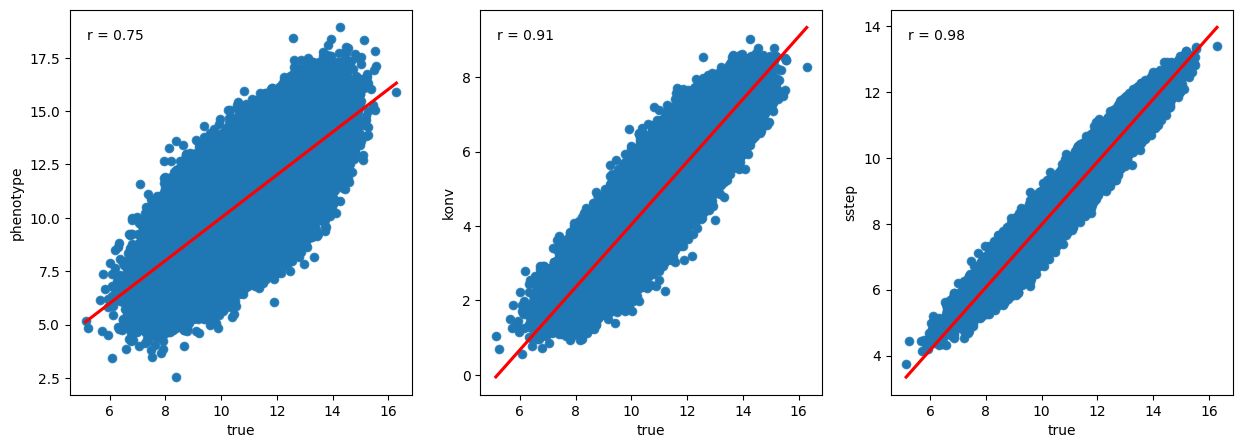

In [12]:
# Show correlation between phenotypes and true genomic values

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=df_snp_pheno_benchmark, x="true", y="phenotype", ax=axs[0])
sns.scatterplot(data=df_snp_pheno_benchmark, x="true", y="konv", ax=axs[1])
sns.scatterplot(data=df_snp_pheno_benchmark, x="true", y="sstep", ax=axs[2])

# add trendline

sns.regplot(data=df_snp_pheno_benchmark, x="true", y="phenotype", ax=axs[0], line_kws={"color": "red"})
sns.regplot(data=df_snp_pheno_benchmark, x="true", y="konv", ax=axs[1] , line_kws={"color": "red"})
sns.regplot(data=df_snp_pheno_benchmark, x="true", y="sstep", ax=axs[2], line_kws={"color": "red"})

# add correlation coefficient

r1 = df_snp_pheno_benchmark["true"].corr(df_snp_pheno_benchmark["phenotype"])
r2 = df_snp_pheno_benchmark["true"].corr(df_snp_pheno_benchmark["konv"])
r3 = df_snp_pheno_benchmark["true"].corr(df_snp_pheno_benchmark["sstep"])

axs[0].text(0.05, 0.95, "r = {:.2f}".format(r1), transform=axs[0].transAxes, va="top")
axs[1].text(0.05, 0.95, "r = {:.2f}".format(r2), transform=axs[1].transAxes, va="top")
axs[2].text(0.05, 0.95, "r = {:.2f}".format(r3), transform=axs[2].transAxes, va="top")


Text(0.05, 0.95, 'r = 0.76')

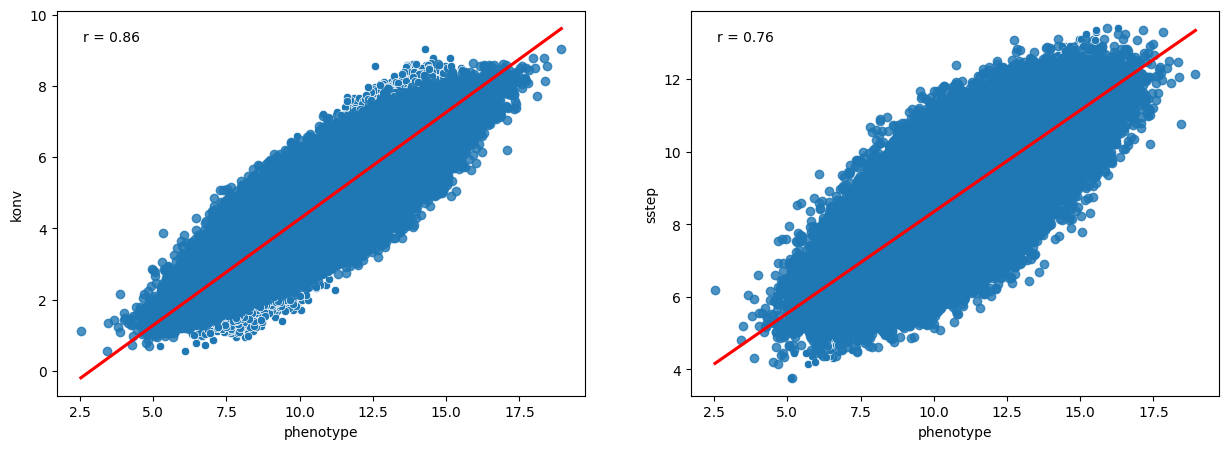

In [13]:
# Show correlation between phenotypes

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=df_snp_pheno_benchmark, x="true", y="konv", ax=axs[0])
sns.scatterplot(data=df_snp_pheno_benchmark, x="true", y="sstep", ax=axs[1])

# add trendline
sns.regplot(data=df_snp_pheno_benchmark, x="phenotype", y="konv", ax=axs[0] , line_kws={"color": "red"})
sns.regplot(data=df_snp_pheno_benchmark, x="phenotype", y="sstep", ax=axs[1], line_kws={"color": "red"})

# add correlation coefficient

r1 = df_snp_pheno_benchmark["phenotype"].corr(df_snp_pheno_benchmark["konv"])
r2 = df_snp_pheno_benchmark["phenotype"].corr(df_snp_pheno_benchmark["sstep"])

axs[0].text(0.05, 0.95, "r = {:.2f}".format(r1), transform=axs[0].transAxes, va="top")
axs[1].text(0.05, 0.95, "r = {:.2f}".format(r2), transform=axs[1].transAxes, va="top")

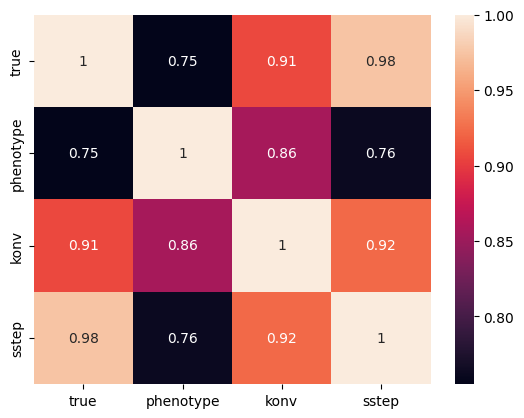

In [14]:
# correlation matrix
corrMatrix = df_snp_pheno_benchmark[["true", "phenotype", "konv", "sstep"]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Text(0, 0.5, 'Value')

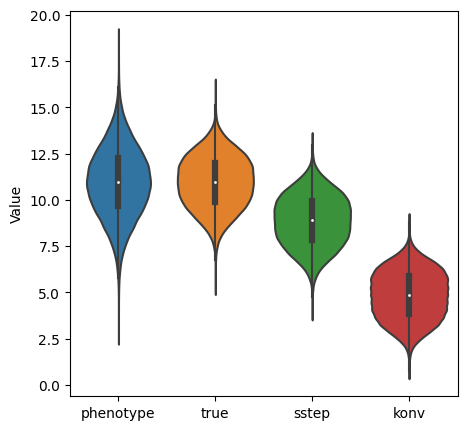

In [15]:
#violinplot of phenotype, true, sstep and konv in one plot

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.violinplot(data=df_snp_pheno_benchmark[["phenotype", "true", "sstep", "konv"]], ax=axs)
axs.set_ylabel("Value")


<Axes: >

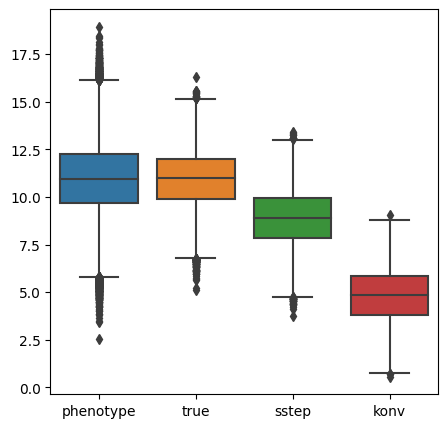

In [16]:
#boxplot of phenotype, true, sstep and konv in one plot

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(data=df_snp_pheno_benchmark[["phenotype", "true", "sstep", "konv"]], ax=axs)

<Axes: xlabel='sstep', ylabel='Count'>

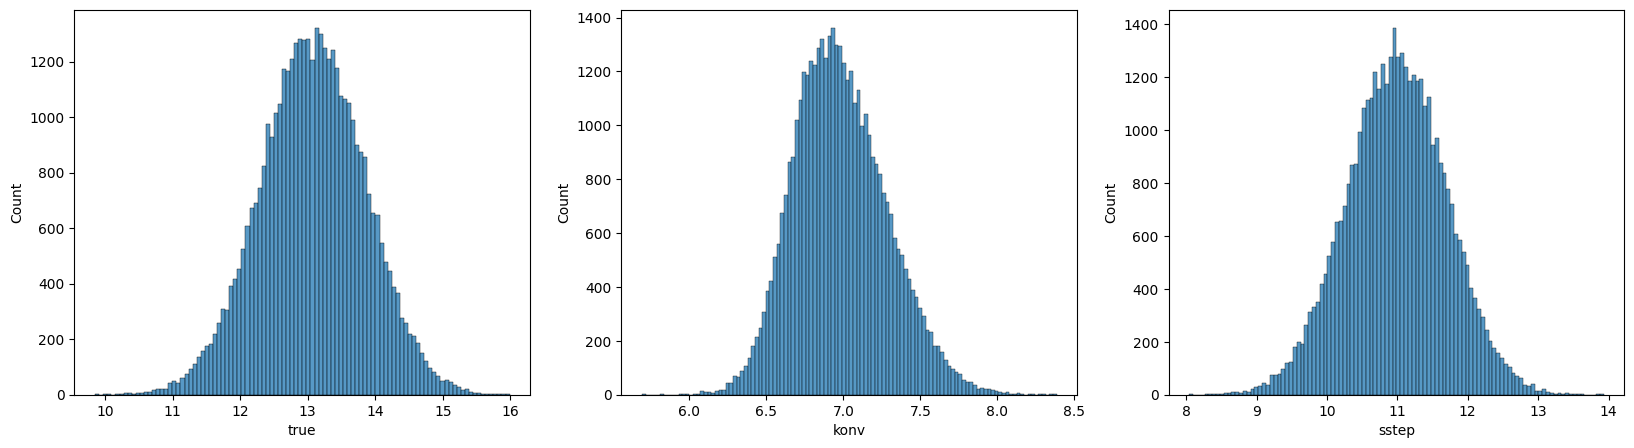

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(data=benchmarkGen30, x="true", ax=axs[0])
sns.histplot(data=benchmarkGen30, x="konv", ax=axs[1])
sns.histplot(data=benchmarkGen30, x="sstep", ax=axs[2])

Text(0.05, 0.95, 'r = 0.8978')

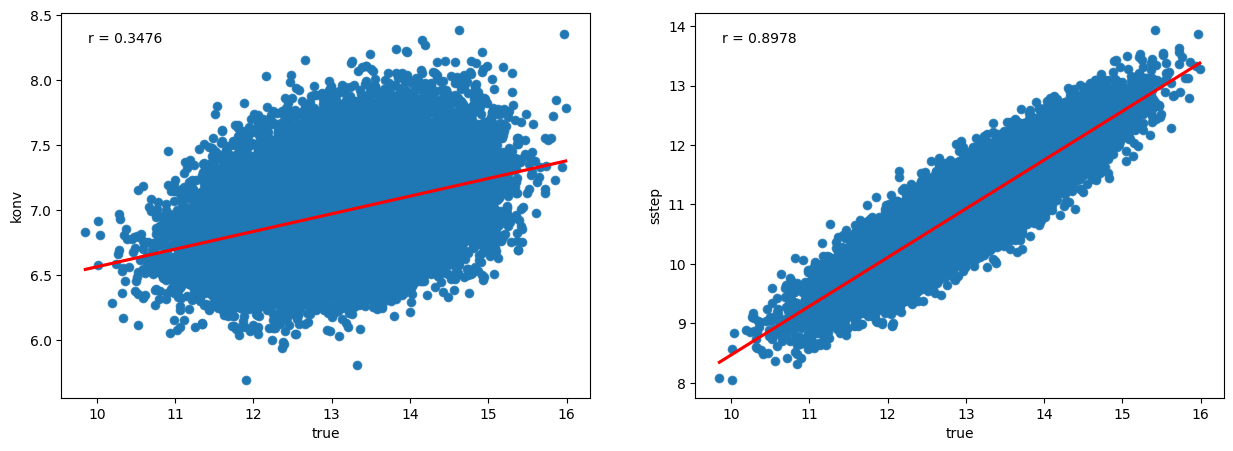

In [26]:

# Show correlation between phenotypes and true genomic values

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=benchmarkGen30, x="true", y="konv", ax=axs[0])
sns.scatterplot(data=benchmarkGen30, x="true", y="sstep", ax=axs[1])

# add trendline

sns.regplot(data=benchmarkGen30, x="true", y="konv", ax=axs[0] , line_kws={"color": "red"})
sns.regplot(data=benchmarkGen30, x="true", y="sstep", ax=axs[1], line_kws={"color": "red"})

# add correlation coefficient

r2 = benchmarkGen30["true"].corr(benchmarkGen30["konv"])
r3 = benchmarkGen30["true"].corr(benchmarkGen30["sstep"])

axs[0].text(0.05, 0.95, "r = {:.4f}".format(r2), transform=axs[0].transAxes, va="top")
axs[1].text(0.05, 0.95, "r = {:.4f}".format(r3), transform=axs[1].transAxes, va="top")
# Show correlation between phenotypes and true genomic values


Text(0, 0.5, 'Value')

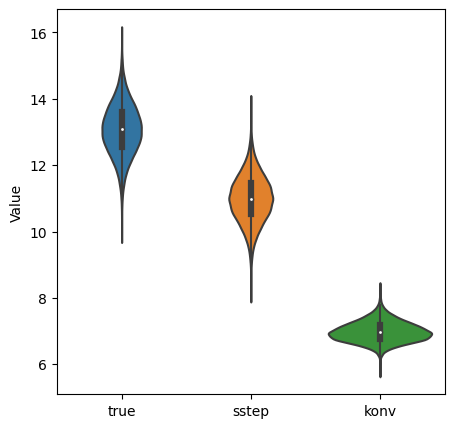

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.violinplot(data=benchmarkGen30[["true", "sstep", "konv"]], ax=axs)
axs.set_ylabel("Value")